In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

C:\Users\vince\anaconda3\envs\anomaly\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
outerdata_train = np.load("outerdata_train_6var.npy")
outerdata_test = np.load("outerdata_test_6var.npy")

nFeat = 7
input_dim = 7

outerdata_train = outerdata_train[outerdata_train[:,nFeat]==0]
outerdata_test = outerdata_test[outerdata_test[:,nFeat]==0]

data_train = outerdata_train[:,0:nFeat]
print('shape of data_train: ', data_train.shape)
data_test = outerdata_test[:,0:nFeat]
print('shape of data_test: ', data_test.shape)

data = np.concatenate((data_train, data_test), axis=0)
print('shape of data: ', data.shape)


shape of data_train:  (499889, 7)
shape of data_test:  (378759, 7)
shape of data:  (878648, 7)


In [3]:
feature_max = np.empty(nFeat)

for i in range(0,data.shape[1]):
    feature_max[i] = np.max(np.abs(data[:,i]))
    if np.abs(feature_max[i]) > 0: 
        data[:,i] = data[:,i]/feature_max[i]
    else:
        pass


## preparing for training

In [4]:
trainsize = outerdata_train.shape[0]


print("Data Shape: ", np.shape(data))
x_train = data[:trainsize]
x_test = data[trainsize:]


# x_train = np.hstack([x_train,y_train.reshape(y_train.shape[0],1)])
# x_test = np.hstack([x_test,y_test.reshape(y_test.shape[0],1)])

image_size = x_train.shape[1]
original_dim = image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = torch.from_numpy(x_train).float()


Data Shape:  (878648, 7)


# Defining Model

In [5]:
intermediate_dim = 128
encoder_dim = 128
batch_size = 1024
latent_dim = 3
epochs_1, epochs_2 = 120, 120
input_dim = 7
lr=0.003

In [55]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(7, 32)
        self.linear2 = torch.nn.Linear(32, 64)
        self.linear3 = torch.nn.Linear(64,32)
        
        self.z_mean = torch.nn.Linear(32, 3)
        self.z_log_var = torch.nn.Linear(32,3)
        
    def latent_space(self, x):
        x1 = torch.nn.functional.relu(self.linear1(x))
        x2 = torch.nn.functional.relu(self.linear2(x1))
        x3 = torch.nn.functional.relu(self.linear3(x2))
        
        z_mean = self.z_mean(x3)

        
        return z_mean
    def forward(self, x):
        x1 = torch.nn.functional.relu(self.linear1(x))
        x2 = torch.nn.functional.relu(self.linear2(x1))
        x3 = torch.nn.functional.relu(self.linear3(x2))
        
        z_mean = self.z_mean(x3)
        z_log_var = self.z_log_var(x3)
        
        epsilon = torch.randn(z_mean.shape)
#        epsilon = torch.randn((latent_dim))
        
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon, z_mean, z_log_var
        
                                                   
        
        

In [70]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(3, 32)
        self.linear2 = torch.nn.Linear(32, 64)
        self.linear3 = torch.nn.Linear(64,32)
        self.linear4 = torch.nn.Linear(32,7)
        
    def forward(self, x):
        
        
        x1 = torch.nn.functional.relu(self.linear1(x))
        x2 = torch.nn.functional.relu(self.linear2(x1))
        x3 = torch.nn.functional.relu(self.linear3(x2))
        generated = torch.sigmoid(self.linear4(x3))
        return generated

In [71]:
class VAE(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VAE,self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def forward(self, x):
        latent, z_mean, z_log_var = self.encoder(x)
        generated = torch.nn.functional.relu(self.decoder(latent))
        return generated, z_mean, z_log_var
        
    def generate(self, n):
        epsilon = torch.randn((n,3))
        print(epsilon)
        return self.decoder(epsilon)

In [72]:
model = VAE(3)

def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    
    #check this is right :bangbang:
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + KLD, reconstruction_loss, KLD


optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training Model

In [73]:
train_loss_list=[]

In [74]:
print("Start training VAE...")

for epoch in range(epochs_1):

    optimizer.zero_grad()

    x_hat, mean, log_var = model(x_train)
    loss, reconstruction_loss, KLD = loss_function(x_train, x_hat, mean, log_var)

    train_loss_list.append(loss.item()/499889)

    loss.backward()
    optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss.item()/499889, "\t KLD: ", + KLD.item()/499889)


Start training VAE...


C:\Users\vince\anaconda3\envs\anomaly\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


	Epoch 1 complete! 	Average Loss:  4.845875284313117 	 KLD:  0.020799301038580565
	Epoch 2 complete! 	Average Loss:  4.799563002986663 	 KLD:  0.012680475221749228
	Epoch 3 complete! 	Average Loss:  4.761571068777268 	 KLD:  0.007657253621241415
	Epoch 4 complete! 	Average Loss:  4.728233167763244 	 KLD:  0.004730459341661349
	Epoch 5 complete! 	Average Loss:  4.6956979449437775 	 KLD:  0.0034570003642371105
	Epoch 6 complete! 	Average Loss:  4.660905220959053 	 KLD:  0.002852723880873429
	Epoch 7 complete! 	Average Loss:  4.623387892112049 	 KLD:  0.0024200931688866177
	Epoch 8 complete! 	Average Loss:  4.5828568942305195 	 KLD:  0.002024064698808448
	Epoch 9 complete! 	Average Loss:  4.538781609517313 	 KLD:  0.0017444004404915392
	Epoch 10 complete! 	Average Loss:  4.491094522984103 	 KLD:  0.0016289926178064656
	Epoch 11 complete! 	Average Loss:  4.439756625970966 	 KLD:  0.0016913642523952816
	Epoch 12 complete! 	Average Loss:  4.386234744113193 	 KLD:  0.0019244865621886808
	Epoc

	Epoch 99 complete! 	Average Loss:  4.020768860687072 	 KLD:  2.6515545264525286e-05
	Epoch 100 complete! 	Average Loss:  4.020769360798097 	 KLD:  2.4240534596922704e-05
	Epoch 101 complete! 	Average Loss:  4.020752857134283 	 KLD:  2.2251949210068386e-05
	Epoch 102 complete! 	Average Loss:  4.020726101194465 	 KLD:  2.0605782216806427e-05
	Epoch 103 complete! 	Average Loss:  4.0207085973086025 	 KLD:  1.9225625434427497e-05
	Epoch 104 complete! 	Average Loss:  4.020724100750367 	 KLD:  1.7977856593196894e-05
	Epoch 105 complete! 	Average Loss:  4.020718099418071 	 KLD:  1.68305586649074e-05
	Epoch 106 complete! 	Average Loss:  4.020716849140509 	 KLD:  1.5782698590935333e-05
	Epoch 107 complete! 	Average Loss:  4.020695844477474 	 KLD:  1.480865785285388e-05
	Epoch 108 complete! 	Average Loss:  4.02067934081366 	 KLD:  1.3948718105898024e-05
	Epoch 109 complete! 	Average Loss:  4.020683341701858 	 KLD:  1.321647890389772e-05
	Epoch 110 complete! 	Average Loss:  4.020642582653349 	 KL

# Generate Data

In [75]:
print(model(x_train[0:10])[0])

tensor([[0.3272, 0.1162, 0.1195, 0.5849, 0.4940, 0.5726, 0.6209],
        [0.3122, 0.0977, 0.1060, 0.5939, 0.4990, 0.5766, 0.6306],
        [0.3222, 0.1096, 0.1145, 0.5886, 0.4913, 0.5762, 0.6222],
        [0.3211, 0.1048, 0.1069, 0.5908, 0.4879, 0.5755, 0.6284],
        [0.3158, 0.1013, 0.1071, 0.5923, 0.4944, 0.5784, 0.6273],
        [0.3196, 0.1046, 0.1059, 0.5901, 0.4862, 0.5840, 0.6237],
        [0.3249, 0.1089, 0.1136, 0.5904, 0.5003, 0.5725, 0.6243],
        [0.3185, 0.1005, 0.1059, 0.5907, 0.4951, 0.5769, 0.6287],
        [0.3198, 0.1067, 0.1133, 0.5916, 0.4979, 0.5736, 0.6210],
        [0.3151, 0.0982, 0.1037, 0.5922, 0.4926, 0.5774, 0.6323]],
       grad_fn=<ReluBackward0>)


In [76]:
print(x_train[0:10])

tensor([[0.2787, 0.0569, 0.0194, 0.6070, 0.5155, 0.6714, 0.6561],
        [0.2465, 0.0345, 0.0051, 0.8700, 0.8715, 0.6390, 0.7017],
        [0.3293, 0.0899, 0.0841, 0.4540, 0.5882, 0.6028, 0.6752],
        [0.6046, 0.0901, 0.0906, 0.6832, 0.5907, 0.6041, 0.6881],
        [0.3198, 0.0528, 0.1129, 0.6486, 0.6512, 0.5829, 0.3785],
        [0.2530, 0.0801, 0.0181, 0.7023, 0.6867, 0.7269, 0.6328],
        [0.3213, 0.1343, 0.0495, 0.7171, 0.2177, 0.5438, 0.6784],
        [0.2830, 0.0473, 0.0356, 0.8473, 0.6749, 0.5724, 0.6311],
        [0.3050, 0.0603, 0.0776, 0.4034, 0.5401, 0.4687, 0.6374],
        [0.2948, 0.0426, 0.0580, 0.7899, 0.6764, 0.6356, 0.6170]])


In [77]:
torch.save(model.state_dict(), "model_saved_2")

In [78]:
print(model.generate(20))

tensor([[-0.0729, -0.6894,  0.2598],
        [ 3.6358,  1.1652,  0.4292],
        [ 1.5079,  0.4950,  0.0672],
        [ 1.1718,  1.3428, -0.6435],
        [-0.0618, -0.0520,  0.6859],
        [ 1.2829, -1.2140, -0.3201],
        [-0.0807, -1.9436, -0.4892],
        [ 0.9971, -1.0019, -0.5224],
        [ 1.1690,  0.2101,  0.1673],
        [-0.1993,  1.3696, -0.1083],
        [ 1.1759,  1.6017,  0.3167],
        [-0.5508, -0.9267,  0.6122],
        [ 0.5159,  0.3527, -0.0392],
        [ 1.1759,  0.4744, -1.6510],
        [ 1.9841,  0.0258,  1.8426],
        [-0.1164, -0.2266,  0.3402],
        [-0.4711, -0.8833,  0.1690],
        [ 2.8058,  0.6220,  0.4848],
        [-1.2177, -2.3533,  1.0265],
        [ 0.7099,  1.2243, -0.5948]])
tensor([[0.3184, 0.1054, 0.1136, 0.5903, 0.4983, 0.5749, 0.6229],
        [0.3032, 0.0774, 0.0779, 0.6035, 0.4883, 0.5981, 0.6444],
        [0.3186, 0.1045, 0.1077, 0.5904, 0.4895, 0.5795, 0.6254],
        [0.3220, 0.1103, 0.1143, 0.5862, 0.4945, 0.5794, 0.62

In [79]:
generated_data = model.generate(400000)

tensor([[ 0.8112, -1.0128, -0.2777],
        [-0.0701,  1.0026,  3.0296],
        [ 2.0275,  2.5679,  0.4164],
        ...,
        [ 0.0964,  0.3786,  0.2835],
        [ 2.2600,  0.4430, -2.0570],
        [ 0.5297,  1.1517,  1.2847]])


In [80]:
generated_data = generated_data.detach().numpy()

In [81]:
print(generated_data)

[[0.31934202 0.10501113 0.11072285 ... 0.49458343 0.5749984  0.62590754]
 [0.31124473 0.08755428 0.09282283 ... 0.5039865  0.5787626  0.62801844]
 [0.3171835  0.09801155 0.10024625 ... 0.49525982 0.58673525 0.6269425 ]
 ...
 [0.31719103 0.10499649 0.11273719 ... 0.4959212  0.5762047  0.62349755]
 [0.3224059  0.10107376 0.10291863 ... 0.49311152 0.58172125 0.630873  ]
 [0.3194849  0.10823129 0.11412923 ... 0.49357393 0.57698965 0.6201076 ]]


In [85]:
np.save("generated_2.npy", generated_data)

In [86]:
generated = np.load("generated_2.npy")

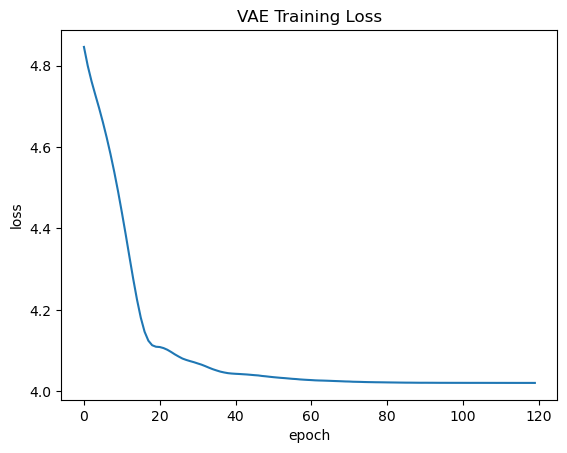

In [83]:
plt.plot(train_loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("VAE Training Loss")
plt.show()

In [ ]:
plt.hist(data[:,0])
plt.show()

In [ ]:
plt.hist(generated[:,0])
plt.show()



In [88]:
model.load_state_dict(torch.load("model_saved"))
model.eval()

VAE(
  (encoder): Encoder(
    (linear1): Linear(in_features=7, out_features=32, bias=True)
    (linear2): Linear(in_features=32, out_features=64, bias=True)
    (linear3): Linear(in_features=64, out_features=32, bias=True)
    (z_mean): Linear(in_features=32, out_features=3, bias=True)
    (z_log_var): Linear(in_features=32, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=3, out_features=32, bias=True)
    (linear2): Linear(in_features=32, out_features=64, bias=True)
    (linear3): Linear(in_features=64, out_features=32, bias=True)
    (linear4): Linear(in_features=32, out_features=7, bias=True)
  )
)

In [89]:
a, b, c = model.encoder(x_train[0:1000])

In [90]:
a = a.detach().numpy()

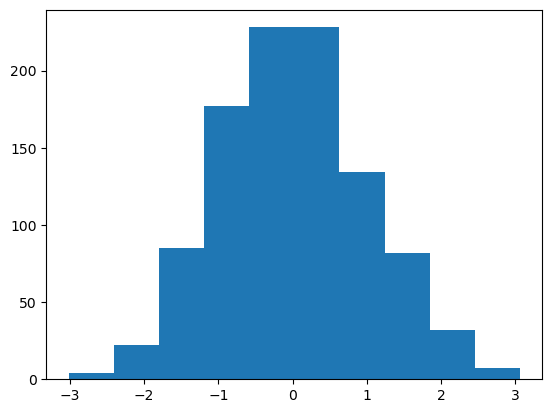

In [91]:
plt.hist(a[1:10000,2])
plt.show()

In [33]:
print(model.generate(3))

tensor([[ 0.5421, -0.6303, -0.6492],
        [-0.8124, -0.1398,  1.2613],
        [-1.6735,  1.2397,  0.2405]])
tensor([[0.2785, 0.1244, 0.0831, 0.5432, 0.4483, 0.5154, 0.5112],
        [0.3598, 0.1133, 0.1087, 0.5902, 0.5025, 0.5982, 0.6056],
        [0.3742, 0.1233, 0.1190, 0.6515, 0.5297, 0.6202, 0.6422]],
       grad_fn=<ReluBackward0>)
